In [1]:
! pip install -q kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c feedback-prize-english-language-learning

  0% 0.00/2.80M [00:00<?, ?B/s]
100% 2.80M/2.80M [00:00<00:00, 232MB/s]


In [6]:
!unzip /content/feedback-prize-english-language-learning.zip

Archive:  /content/feedback-prize-english-language-learning.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [7]:
import pandas as pd
import numpy as np
import re
# for removing accented and special chracters
import unicodedata
# for stopwords Removal
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
# for calculating Polarity and Subjectivity
from textblob import TextBlob
# for Wordscloud
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

import keras
import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer


import nltk
from nltk.corpus import stopwords
from textblob import Word
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [9]:
train_df=pd.read_csv('./train.csv')
train_df.head(5)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [11]:
test_df=pd.read_csv('./test.csv')
test_df

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [12]:
# Basic Statistic
train_df[['cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions']].describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
cohesion,3911.000000,3.127077,0.662542,1.000000,2.500000,3.000000,3.500000,5.000000
syntax,3911.000000,3.028254,0.644399,1.000000,2.500000,3.000000,3.500000,5.000000
vocabulary,3911.000000,3.235745,0.583148,1.000000,3.000000,3.000000,3.500000,5.000000
phraseology,3911.000000,3.116850,0.655997,1.000000,2.500000,3.000000,3.500000,5.000000
grammar,3911.000000,3.032856,0.699841,1.000000,2.500000,3.000000,3.500000,5.000000
conventions,3911.000000,3.081053,0.671450,1.000000,2.500000,3.000000,3.500000,5.000000


In [13]:
train_df['full_text'][0]

"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.\n\nmost students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go t

#Clean Data

In [14]:
train_df['full_text'] = train_df["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)
test_df['full_text'] = test_df["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

In [15]:
# lets create a function to remove accented characters
def remove_accented_chars(text):
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

# lets apply the function
train_df['full_text'] = train_df.apply(lambda x: remove_accented_chars(x['full_text']), axis = 1)

In [16]:
# Create a function to remove special characters
def remove_special_characters(text):
    pat = r'[^a-zA-z0-9]' 
    return re.sub(pat, ' ', text)
 
# lets apply this function
train_df['full_text'] = train_df.apply(lambda x: remove_special_characters(x['full_text']), axis = 1)

In [17]:
train_df['full_text'][0]

'I think that students would benefit from learning at home because they wont have to change and get up early in the morning to shower and do there hair  taking only classes helps them because at there house they ll be pay more attention  they will be comfortable at home   The hardest part of school is getting ready  you wake up go brush your teeth and go to your closet and look at your cloths  after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain  Then you ll have to change  with the online classes you can wear anything and stay home and you wont need to stress about what to wear   most students usually take showers before school  they either take it before they sleep or when they wake up  some students do both to smell good  that causes them do miss the bus and effects on there lesson time cause they come late to school  when u have online classes u wont need to miss lessons cause you can get everything set up and go take 

In [18]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [20]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [21]:
stop = stopwords.words('english')
stop_words = []
from nltk.tokenize import word_tokenize

text_tokens = word_tokenize(train_df['full_text'][0])

tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]

print(tokens_without_sw)

['I', 'students', 'benefit', 'learning', 'home', 'change', 'early', 'morning', 'shower', 'hair', 'taking', 'classes', 'helps', 'house', 'pay', 'attention', 'comfortable', 'home', 'The', 'hardest', 'part', 'school', 'ready', 'wake', 'brush', 'teeth', 'closet', 'cloths', 'picked', 'outfit', 'mirror', 'youll', 'stain', 'Then', 'change', 'online', 'classes', 'wear', 'stay', 'home', 'stress', 'wear', 'students', 'showers', 'school', 'sleep', 'wake', 'students', 'smell', 'miss', 'bus', 'effects', 'lesson', 'time', 'late', 'school', 'online', 'classes', 'miss', 'lessons', 'set', 'shower', 'ready', 'home', 'comfortable', 'pay', 'attention', 'advantage', 'smarter', 'pass', 'classmates', 'class', 'work', 'public', 'schools', 'difficult', 'teacher', 'teach', 'students', 'understand', 'students', 'fail', 'repeat', 'class']


#Feature Engineering

In [22]:
data=train_df[['cohesion','syntax','vocabulary','phraseology','grammar','conventions']]
def count(x):
    for i in x:
        return x.value_counts()
count(data)

cohesion  syntax  vocabulary  phraseology  grammar  conventions
3.0       3.0     3.0         3.0          2.5      3.0            19
3.5       3.5     3.5         3.5          3.5      3.5            17
2.5       2.5     3.0         2.5          2.5      3.0            17
3.0       3.0     3.0         3.0          2.5      2.5            15
2.5       2.5     3.0         3.0          2.5      2.5            15
                                                                   ..
3.0       3.0     3.5         3.5          2.5      2.5             1
                              3.0          4.0      4.0             1
                                           3.0      2.0             1
                                           2.0      2.5             1
5.0       5.0     5.0         5.0          5.0      5.0             1
Length: 1768, dtype: int64

In [23]:
train_df['length'] = train_df['full_text'].apply(len)

###Text Polarity

In [24]:
def get_polarity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    pol = textblob.sentiment.polarity
    return pol

# lets apply the function
train_df['polarity'] = train_df['full_text'].apply(get_polarity)

###Text Subjectivity

In [25]:
def get_subjectivity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    subj = textblob.sentiment.subjectivity
    return subj

# lets apply the Function
train_df['subjectivity'] = train_df['full_text'].apply(get_subjectivity)

In [26]:
train_df[['length','polarity','subjectivity']].describe()

,length,polarity,subjectivity
count,3911.000000,3911.000000,3911.000000
mean,2334.522373,0.187967,0.496602
std,1033.406009,0.120355,0.086626
min,82.000000,-0.284394,0.000000
25%,1597.000000,0.112575,0.442590
50%,2173.000000,0.189519,0.495140
75%,2866.500000,0.267591,0.547269
max,6044.000000,0.680000,0.925926


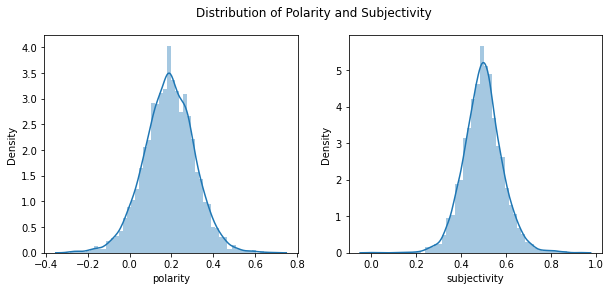

In [27]:
plt.rcParams['figure.figsize'] = (10, 4)

plt.subplot(1, 2, 1)
sns.distplot(train_df['polarity'])

plt.subplot(1, 2, 2)
sns.distplot(train_df['subjectivity'])

plt.suptitle('Distribution of Polarity and Subjectivity')
plt.show()

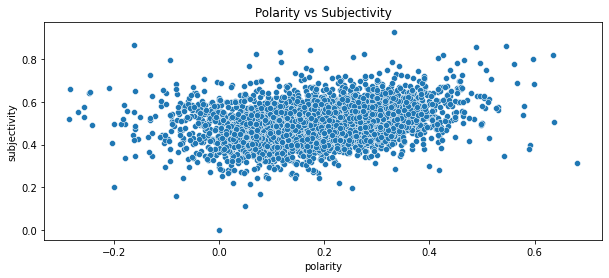

In [28]:
sns.scatterplot(train_df['polarity'], train_df['subjectivity'])
plt.title('Polarity vs Subjectivity')
plt.show()

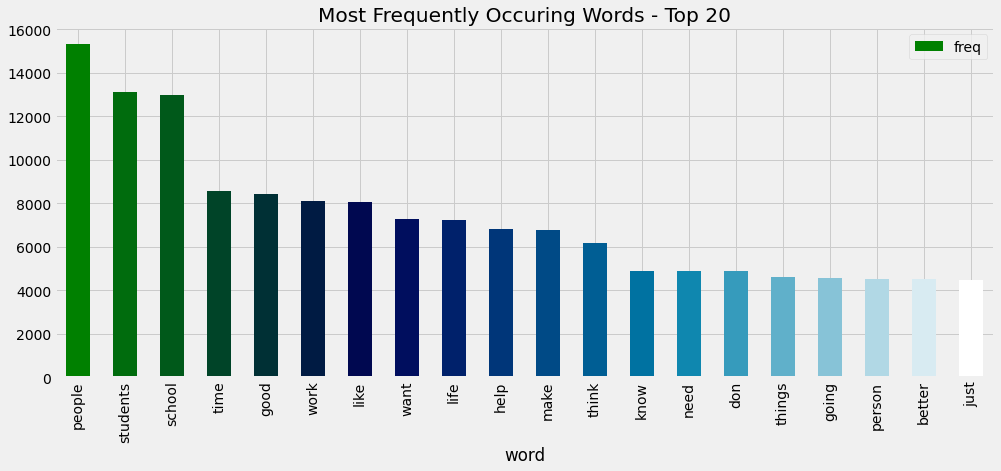

In [29]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train_df['full_text'])
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

plt.style.use('fivethirtyeight')
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 20")
plt.show()

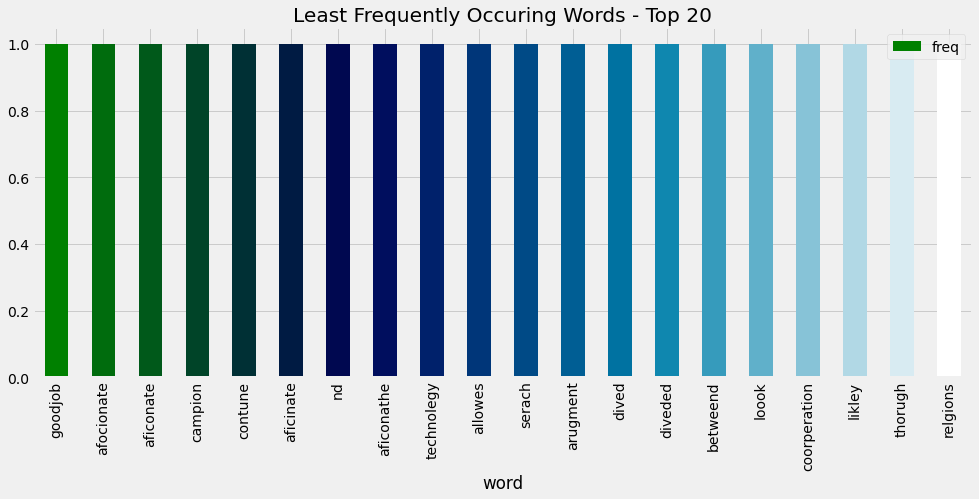

In [30]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train_df['full_text'])
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

plt.style.use('fivethirtyeight')
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.tail(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Least Frequently Occuring Words - Top 20")
plt.show()

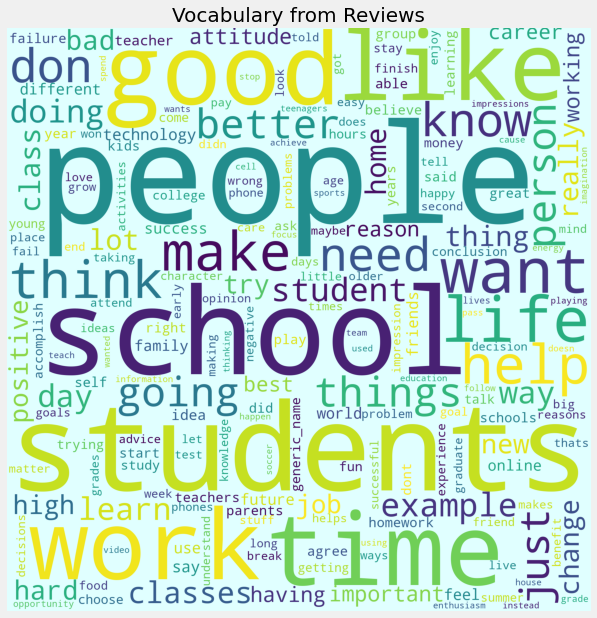

In [31]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train_df['full_text'])
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

wordcloud = WordCloud(background_color = 'lightcyan', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Reviews", fontsize = 20)
plt.show()

###Character Count

In [32]:
train_df['ncharacters'] = train_df['full_text'].str.len()
avg_char = round(train_df['ncharacters'].mean())
max_char = round(train_df['ncharacters'].max())
print('Average length: {}'.format(avg_char))
print('Max length: {}'.format(max_char))

Average length: 2335
Max length: 6044


Text(0.5, 1.0, 'Character Count')

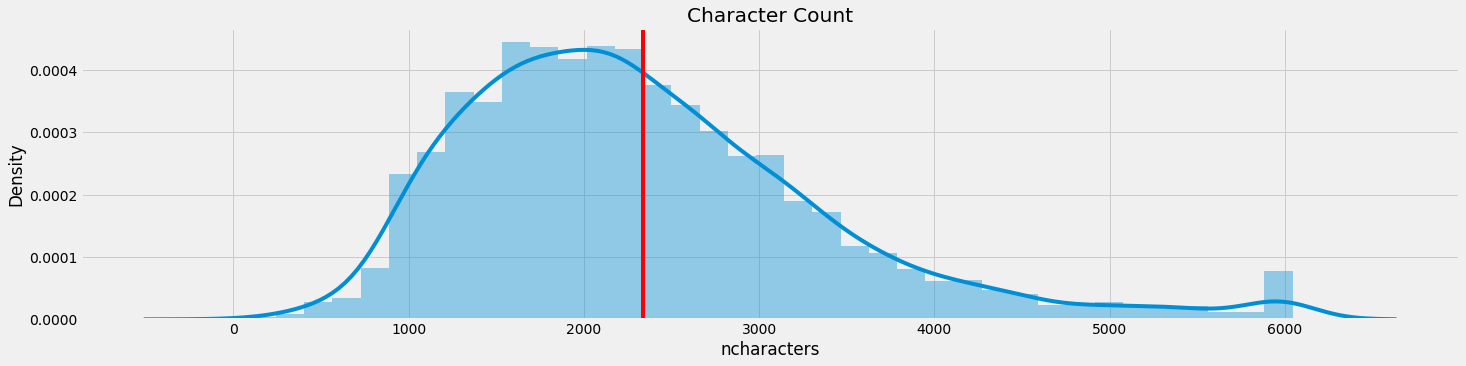

In [33]:
plt.figure(figsize = (22,5))
sns.distplot(train_df['ncharacters'])
plt.axvline(x = avg_char, color = 'red')
plt.title('Character Count')

###Word Count

In [34]:
train_df['nwords'] = train_df['full_text'].apply(lambda x: len(x.split()))
avg_words = round(train_df['nwords'].mean())
max_words = round(train_df['nwords'].max())
print('Average length: {}'.format(avg_words))
print('Max length: {}'.format(max_words))

Average length: 436
Max length: 1261


Text(0.5, 1.0, 'Word count')

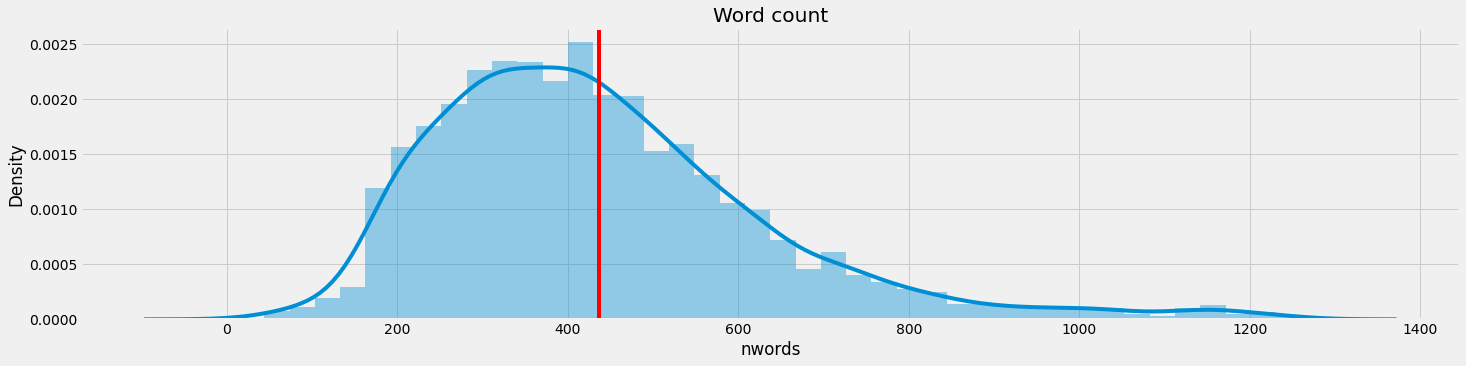

In [35]:
plt.figure(figsize = (22,5))
sns.distplot(train_df['nwords'])
plt.axvline(x = avg_words, color = 'red')
plt.title('Word count')

In [36]:
def plot_distribution_per_score(c): 
    scores = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
    figure, axes = plt.subplots(nrows = 1, ncols = 6, figsize = (22,5))
    for i, col in enumerate(scores):
        conditionlist = [
        (train_df[col] >= 4.5) ,
        (train_df[col] >= 2) & (train_df[col] < 4.5),
        (train_df[col] < 2)]
        choicelist = ['High', 'Mid', 'Low']
        train_df['performance'] = np.select(conditionlist, choicelist, default='Not Specified')

        mask = train_df.performance != 'Mid'
        sns.kdeplot(train_df[mask][c], hue = train_df.performance, ax = axes[i])
        axes[i].set_title(col)

        mask_low = train_df.performance == 'Low'
        avg_low = train_df[mask_low][c].mean()
        axes[i].axvline(x = avg_low, color = 'green', linestyle = '--')

        mask_high = train_df.performance == 'High'
        avg_high = train_df[mask_high][c].mean()
        axes[i].axvline(x = avg_high, color = 'orange', linestyle = '--')

        del train_df['performance']

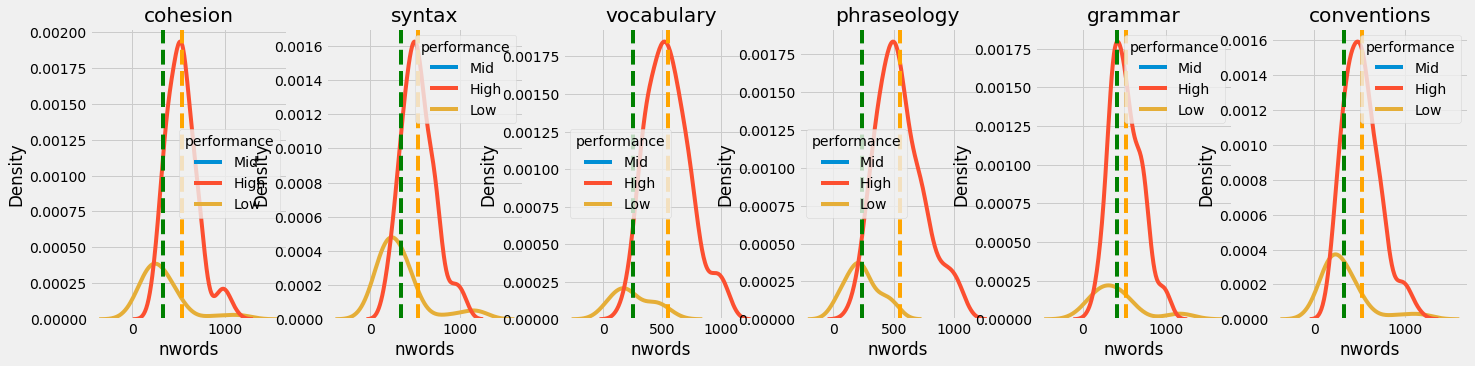

In [37]:
plot_distribution_per_score('nwords')

###Correlations

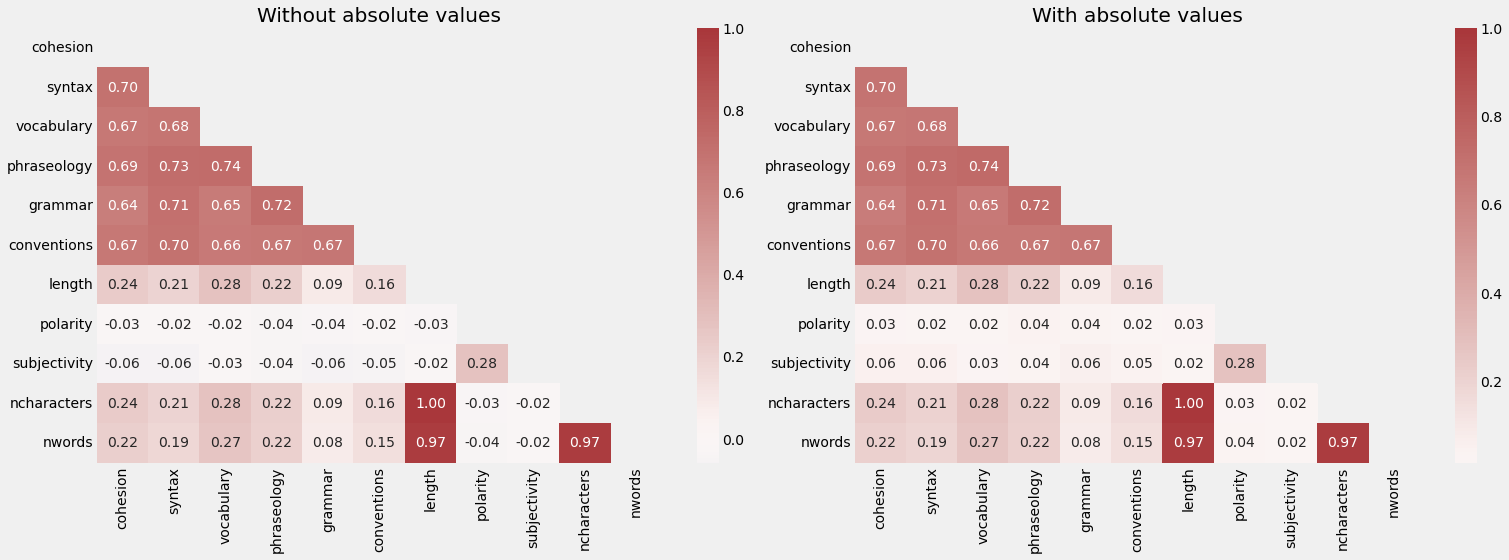

In [39]:
corr= train_df.select_dtypes(['int','float']).corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (22,8))
# Heatmap without absolute values
sns.heatmap(corr, mask=matrix, center = 0, cmap = 'vlag', ax = axes[0], 
            annot=True, fmt='.2f').set_title('Without absolute values')
# Heatmap with absolute values
sns.heatmap(abs(corr), mask=matrix, center = 0, cmap = 'vlag', ax = axes[1], 
           annot=True, fmt='.2f').set_title('With absolute values')

fig.tight_layout(h_pad=1.0, w_pad=0.5)

Text(0.5, 1.0, 'Subjetivity Distribution')

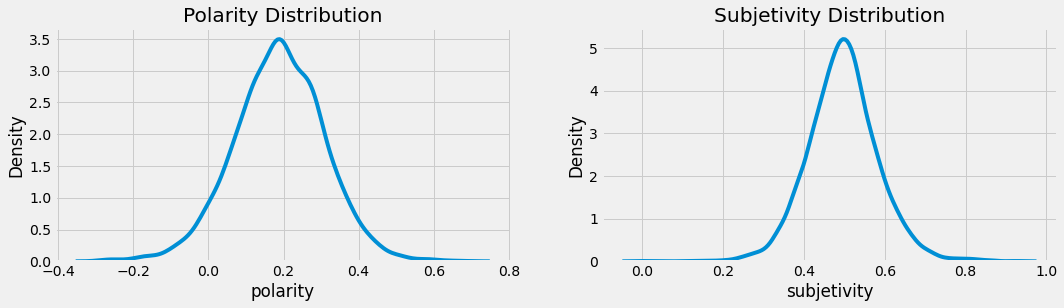

In [40]:
from textblob import TextBlob

train_df['polarity'] = train_df['full_text'].apply(lambda x: TextBlob(x).sentiment[0])
train_df['subjetivity'] = train_df['full_text'].apply(lambda x: TextBlob(x).sentiment[1])
figure, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16,4))
sns.kdeplot(train_df['polarity'], ax = axes[0])
axes[0].set_title('Polarity Distribution')
sns.kdeplot(train_df['subjetivity'], ax = axes[1])
axes[1].set_title('Subjetivity Distribution')

#Modeling

In [42]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 24.9 MB/s 
     |████████████████████████████████| 163 kB 72.4 MB/s 
     |████████████████████████████████| 7.6 MB 59.2 MB/s 


In [43]:
from transformers import AutoModel
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import gc

# ----------
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [44]:
import transformers
print('transformers version:',transformers.__version__)

transformers version: 4.23.1


In [45]:
config = {
    'model': 'bert-base-uncased',
    'dropout': 0.5,
    'max_length': 512,
    'batch_size': 16,
    'epochs': 5,
    'lr': 2e-5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'scheduler': 'CosineAnnealingWarmRestarts'
}

###Tokenizer, Dataset

In [46]:
df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [47]:
tokenizer = AutoTokenizer.from_pretrained(config['model'])

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [48]:
class EssayDataset:
    def __init__(self, df, config, tokenizer=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.classes = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
        self.max_len = config['max_length']
        self.tokenizer = tokenizer
        self.is_test = is_test
        
    def __getitem__(self,idx):
        sample = self.df['full_text'][idx]
        tokenized = tokenizer.encode_plus(sample,
                                          None,
                                          add_special_tokens=True,
                                          max_length=self.max_len,
                                          truncation=True,
                                          padding='max_length'
                                         )
        inputs = {
            "input_ids": torch.tensor(tokenized['input_ids'], dtype=torch.long),
            "token_type_ids": torch.tensor(tokenized['token_type_ids'], dtype=torch.long),
            "attention_mask": torch.tensor(tokenized['attention_mask'], dtype=torch.long)
        }
        
        if self.is_test == True:
            return inputs
        
        label = self.df.loc[idx,self.classes].to_list()
        targets = {
            "labels": torch.tensor(label, dtype=torch.float32),
        }
        
        return inputs, targets
    
    def __len__(self):
        return len(self.df)

In [49]:
train_df, val_df = train_test_split(df,test_size=0.2,random_state=1357,shuffle=True)
print('dataframe shapes:',train_df.shape, val_df.shape)

dataframe shapes: (3128, 8) (783, 8)


In [50]:
train_ds = EssayDataset(train_df, config, tokenizer=tokenizer)
val_ds = EssayDataset(val_df, config, tokenizer=tokenizer)
test_ds = EssayDataset(test_df, config, tokenizer=tokenizer, is_test=True)

In [51]:
train_ds[0][0]['input_ids'].shape

torch.Size([512])

In [66]:
train_loader = torch.utils.data.DataLoader(train_ds,
                                           batch_size=config['batch_size'],
                                           shuffle=True,
                                           num_workers=2,
                                           pin_memory=True
                                          )
val_loader = torch.utils.data.DataLoader(val_ds,
                                         batch_size=config['batch_size'],
                                         shuffle=True,
                                         num_workers=2,
                                         pin_memory=True
                                        )
test_loader = torch.utils.data.DataLoader(test_ds,
                                         batch_size=1,
                                         shuffle=False,
                                         num_workers=1,
                                         pin_memory=True
                                        )


In [53]:
print('loader shapes:',len(train_loader), len(val_loader))

loader shapes: 196 49


In [54]:
class EssayModel(nn.Module):
    def __init__(self,config,num_classes=6):
        super(EssayModel,self).__init__()
        self.model_name = config['model']
        self.encoder = AutoModel.from_pretrained(self.model_name)
        self.dropout = nn.Dropout(config['dropout'])
        self.fc1 = nn.Linear(self.encoder.config.hidden_size,64)
        self.fc2 = nn.Linear(64,num_classes)
        
    def forward(self,inputs):
        _,outputs = self.encoder(**inputs, return_dict=False)
        outputs = self.dropout(outputs)
        outputs = self.fc1(outputs)
        outputs = self.fc2(outputs)
        return outputs

In [55]:
# Puilding the model
class Trainer:
    def __init__(self, model, loaders, config):
        self.model = model
        self.train_loader, self.val_loader = loaders
        self.config = config
        self.input_keys = ['input_ids','token_type_ids','attention_mask']
        
        self.optim = self._get_optim()
        
        self.scheduler_options = {
            'CosineAnnealingWarmRestarts': torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optim, T_0=5,eta_min=1e-7),
            'ReduceLROnPlateau': torch.optim.lr_scheduler.ReduceLROnPlateau(self.optim, 'min', min_lr=1e-7),
            'StepLR': torch.optim.lr_scheduler.StepLR(self.optim,step_size=2)
        }
        
        self.scheduler = self.scheduler_options[self.config['scheduler']]
        
        self.train_losses = []
        self.val_losses = []
        
    def _get_optim(self):
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.config['lr'])
        return optimizer

        
    def loss_fn(self, outputs, targets):
        colwise_mse = torch.mean(torch.square(targets - outputs), dim=0)
        loss = torch.mean(torch.sqrt(colwise_mse), dim=0)
        return loss
    
    def train_one_epoch(self,epoch):
        
        running_loss = 0.
        progress = tqdm(self.train_loader, total=len(self.train_loader))
        
        for i,(inputs,targets) in enumerate(progress):
            
            self.optim.zero_grad()
            
            inputs = {k:inputs[k].to(device=config['device']) for k in inputs.keys()}
            targets = targets['labels'].to(device=config['device'])
            
            outputs = self.model(inputs)
            
            loss = self.loss_fn(outputs, targets)
            running_loss += loss.item()
            
            loss.backward()
            self.optim.step()
            
            if self.config['scheduler'] == 'CosineAnnealingWarmRestarts':
                self.scheduler.step(epoch-1+i/len(self.train_loader)) # as per pytorch docs
            
            del inputs, targets, outputs, loss
            
        if self.config['scheduler'] == 'StepLR':
            self.scheduler.step()
            
        train_loss = running_loss/len(self.train_loader)
        self.train_losses.append(train_loss)
        
    @torch.no_grad()
    def valid_one_epoch(self,epoch):
        
        running_loss = 0.
        progress = tqdm(self.val_loader, total=len(self.val_loader))
        
        for (inputs, targets) in progress:
            
            inputs = {k:inputs[k].to(device=config['device']) for k in inputs.keys()}
            targets = targets['labels'].to(device=config['device'])
            
            outputs = self.model(inputs)
            
            loss = self.loss_fn(outputs, targets)
            running_loss += loss.item()
            
            del inputs, targets, outputs, loss
            
        
        val_loss = running_loss/len(self.val_loader)
        self.val_losses.append(val_loss)
        
        if config['scheduler'] == 'ReduceLROnPlateau':
            self.scheduler.step(val_loss)
            
    
    def test(self, test_loader):
        
        preds = []
        for (inputs) in test_loader:
            inputs = {k:inputs[k].to(device=config['device']) for k in inputs.keys()}
            
            outputs = self.model(inputs)
            preds.append(outputs.detach().cpu())
            
        preds = torch.concat(preds)
        return preds
    
    def fit(self):
        
        fit_progress = tqdm(
            range(1, self.config['epochs']+1),
            leave = True,
            desc="Training..."
        )
        
        for epoch in fit_progress:
            
            self.model.train()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']} | training...")
            self.train_one_epoch(epoch)
            self.clear()
            
            self.model.eval()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']} | validating...")
            self.valid_one_epoch(epoch)
            self.clear()

            print(f"{'-'*30} EPOCH {epoch} / {self.config['epochs']} {'-'*30}")
            print(f"train loss: {self.train_losses[-1]}")
            print(f"valid loss: {self.val_losses[-1]}\n\n")
            
    
    def clear(self):
        gc.collect()
        torch.cuda.empty_cache()

In [56]:
model = EssayModel(config).to(device=config['device'])
trainer = Trainer(model, (train_loader, val_loader), config)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [57]:
trainer.fit()

Training...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 1 / 5 ------------------------------
train loss: 1.2021035764898573
valid loss: 0.5292350011212485




  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 2 / 5 ------------------------------
train loss: 0.5568628853985241
valid loss: 0.5572736208536186




  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 3 / 5 ------------------------------
train loss: 0.514415552421492
valid loss: 0.4932274307523455




  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 4 / 5 ------------------------------
train loss: 0.4839774625641959
valid loss: 0.5212018362113408




  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 5 / 5 ------------------------------
train loss: 0.47447401300376774
valid loss: 0.5072494483723933




In [58]:
losses_df = pd.DataFrame({'epoch':list(range(1,config['epochs'] + 1)),
                          'train_loss':trainer.train_losses, 
                          'val_loss': trainer.val_losses
                         })
losses_df

,epoch,train_loss,val_loss
0,1,1.202104,0.529235
1,2,0.556863,0.557274
2,3,0.514416,0.493227
3,4,0.483977,0.521202
4,5,0.474474,0.507249


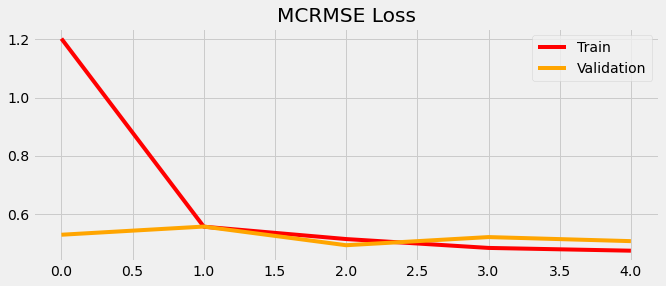

In [59]:
plt.plot(trainer.train_losses, color='red')
plt.plot(trainer.val_losses, color='orange')
plt.title('MCRMSE Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

In [64]:
len(test_ds)

3

In [67]:
result_test = trainer.test(test_loader)

In [69]:
result_test.tolist()

[[3.0608081817626953,
  2.949364185333252,
  3.165255069732666,
  3.033977746963501,
  2.9332196712493896,
  2.9722816944122314],
 [2.7425990104675293,
  2.615006685256958,
  2.8463945388793945,
  2.6583974361419678,
  2.544377565383911,
  2.671952962875366],
 [3.743726968765259,
  3.7356832027435303,
  3.8564937114715576,
  3.8057351112365723,
  3.749464273452759,
  3.789888858795166]]

In [72]:
final_result = [[round(c,2) for c in i] for i in result_test.tolist()]
final_result

[[3.06, 2.95, 3.17, 3.03, 2.93, 2.97],
 [2.74, 2.62, 2.85, 2.66, 2.54, 2.67],
 [3.74, 3.74, 3.86, 3.81, 3.75, 3.79]]

In [85]:
df_result = pd.DataFrame(final_result, columns=['cohesion','syntax','vocabulary','phraseology','grammar','conventions'], index=None)
df_result

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,3.06,2.95,3.17,3.03,2.93,2.97
1,2.74,2.62,2.85,2.66,2.54,2.67
2,3.74,3.74,3.86,3.81,3.75,3.79


In [86]:
df_result['text_id'] = test_df['text_id']
# df_result = df_result.set_index(['text_id'])
df_result

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,text_id
0,3.06,2.95,3.17,3.03,2.93,2.97,0000C359D63E
1,2.74,2.62,2.85,2.66,2.54,2.67,000BAD50D026
2,3.74,3.74,3.86,3.81,3.75,3.79,00367BB2546B


In [87]:
df_result.to_csv('/content/my_result.csv', index=False)